# Gradient Descent in Pytorch

### Introduction

So in the last lesson, we learned the gradient descent technique for finding the value of a weight that will result in a neuron that best makes predictions.  Remember that with gradient descent, the goal is to find the value of our weight, $w$, by starting with a random value and then descending along a cost curve. 

<img src="cost-curve-slopes.png" width="50%">

So for example, in the last lesson, we started at a random weight value of -2, and then repeatedly calculated the slope of our cost curve at that weight, and moved in the opposite direction, by an amount proportional to that weight. 

```python
weight = -2
learning_rate = .01
for idx in range(0, 10):
    weight =  weight - learning_rate*sse_slope(weight)
weight
```

In this lesson, let's see how this same technique is performed in Pytorch.

### Loading our Data

In [13]:
import pandas as pd
url = './cell_data.csv'
df = pd.read_csv(url, index_col = 0)
df[:2]

,mean_area,is_cancerous
0,1.001,1
1,1.326,1


In [14]:
X = df[['mean_area']]
target = df['is_cancerous']

X[:2]

,mean_area
0,1.001
1,1.326


In [15]:
target[:2]

0    1
1    1
Name: is_cancerous, dtype: int64

Ok now above we've loaded our features and target values.  But we'll need to change them to Pytorch tensors.  We can do that with the following.

In [16]:
import torch
y_tensor = torch.tensor(target.values).float()
y_tensor[:2]

tensor([1., 1.])

In [17]:
X_tensor = torch.tensor(X.values).float()
X_tensor[:2]

tensor([[1.0010],
        [1.3260]])

> The `float()` at the end simply makes sure that the values in our `X_tensor` and `y_tensor` are floats -- float just means decimals.  

Ok, so now that we've converted our data, let's go back to creating our neural network in Pytorch.  And then we'll move towards performing gradient descent in Pytorch.

### Creating our Neural Network

Ok, so remember that to create our neural network, with a single neuron we'll declare our linear layer followed by our sigmoid function.

In [18]:
import torch.nn as nn

net = nn.Sequential(
    nn.Linear(1, 1),
    nn.Sigmoid()
)

So in the linear layer above, the first argument of `1` specifies that we will take in a single feature, and the second argument of `1` says that the layer consists of a single neuron.

> For this reason, our linear layer has a single single tensor, of length 1.

In [19]:
net[0]._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[-0.3706]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([0.1327], requires_grad=True))])

And remember that if we pass through data to our neural network 

In [21]:
net(X_tensor)[:4]

tensor([[0.4407],
        [0.4112],
        [0.4223],
        [0.4974]], grad_fn=<SliceBackward>)

Ok, so now currently we don't expect these predictions to be any good.  To improve our predictions we'll need to train our neural network through gradient descent.

### All our fancy tools

Remember that with gradient descent, we start with an random parameter (which we did above), and then repeatedly update this parameter according to the following formula:

$\theta_{next} = \theta_{current} -\eta*slope\_at(\theta_{current})$



Which, remember in code, looks something like the following:
    
```python
w_1 = .4 # just some random value
learning_rate = .01
for idx in range(0, 10):
    weight =  weight - learning_rate*sse_slope(weight)
weight
```

So in Pytorch, we are given tools for each of the components above.  For example, for the learning rate, we use `optim.Adam`.

In [22]:
import torch.optim as optim

opt = optim.Adam(net.parameters(), lr=0.001)

> The `lr` there is our learning rate, so above set our learning rate to `.001`.

And instead of building our own sum of square errors loss function, we can get this loss function from Pytorch.

In [36]:
criterion = nn.MSELoss()

> MSE actually stands for mean squared loss.  This is essentially the same as our SSE, except that now instead of adding up the loss across all of our observations, we calculate the average loss by adding up the loss across all observations and then dividing by tht number of observations.

### Gradient Descent just once

Ok, so remember that visually our procedure for gradient descent looks something like the following, where we start at a random weight, and repeatedly update that weight as we descent along our cost curve:

<img src='./grad-descent.png' width="80%">

And if we think about how this translates into a procedure, we'll want to:
1. Start with our random weights in our neural network and make our prediction, 
2. See how off our prediction is according to our cost function (mean square error), and
3. Update our weight by the negative slope of the cost curve at that weight times the learning rate.

$weight = weight - learning\_rate*sse\_slope(weight)$

So in Pytorch we already have our random weights and then we make our prediction:

In [30]:
y_hat = net(X_tensor)
y_hat[:3]

tensor([[0.4407],
        [0.4112],
        [0.4223]], grad_fn=<SliceBackward>)

We then use our loss which we defined above as `loss = nn.MSELoss()`, to see how far off these predictions are from the observed targets.

In [40]:
loss = criterion(y_hat, y_tensor)

So this is the loss at the initial parameter, next we find the slope of the cost curve at that initial value with `loss.backward()`.

In [41]:
loss.backward()

> This is akin to our `slope_at` function.

And then we update our parameter with the `opt.step` function.

In [42]:
opt.step()

That's it.  So notice that our procedure was the same as above.

1. Start with our random weights in our neural network and make our prediction, 
2. See how off our prediction is according to our cost function (mean square error), and
3. Update our weight by the negative slope of the cost curve at that weight times the learning rate.

In [ ]:
y_hat = net(X_tensor)             # 1. start with random weights and make the prediction
loss = criterion(y_hat, y_tensor) # 2. See how off the prediction is according to the cost function
loss.backward()                   # 3a. Calculate the slope of the cost curve at that weight
opt.step()                        # 4. Update the parameters based on the learning rate and the calculated slope 

### Training with gradient descent

So above, we moved through our process of gradient descent in Pytorch.  But all those steps above did was move us from our initial parameter, to then take one step forward to the next one.  What really want to do is repeat this process a number of times so that we approach the minimum of ur cost curve.  

<img src='./grad-descent.png' width="80%">

Let's do that now.  Ok, so we'll start fromo scratch, beginning with creating our neural network.

In [153]:
net = nn.Sequential(
    nn.Linear(1, 1),
    nn.Sigmoid()
)
net

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)

Then we'll create our loss function.

In [154]:
criterion = torch.nn.MSELoss()

And then our optimizer, where we specify our learning rate.

In [155]:
optim = torch.optim.Adam(net.parameters(), lr = .001)

And now instead of performing gradient descent, where we descend along the cost curve by updating our parameters through the formula $\theta_{next} = \theta_{current} -\eta*slope\_at(\theta_{current})$.

So below, we perform this procedure 10,000 times.

In [156]:
n_epochs=10000
train_losses = []
for it in range(n_epochs): 
    outputs = net(X_tensor) # 1. Make the prediction
    loss = criterion(outputs, y_tensor.view(-1, 1)) # 2. See how off the prediction is according to the cost function
    optim.zero_grad() # Here we zero out any previously calculated slopes
    loss.backward() # 3. Then calculate the slope of the cost curve at that weight
    optim.step() # 4. Update the parameters based on the learning rate and the calculated slope 
    train_losses.append(loss.item()) 

> For each iteration above, we store the training loss so that we can plot how we descend along the cost curve.

Ok, now let's see how our cost curve decreased as we performed our gradient descent procedure above.  With each iteration, we stored our training loss `train_losses.append()`.  And can see the list of losses here:

In [157]:
train_losses[:5]

[0.3213537037372589,
 0.32120704650878906,
 0.3210606873035431,
 0.3209145963191986,
 0.32076868414878845]

So now if we plot the loss with each iteration, we see that we do descend along our cost curve.

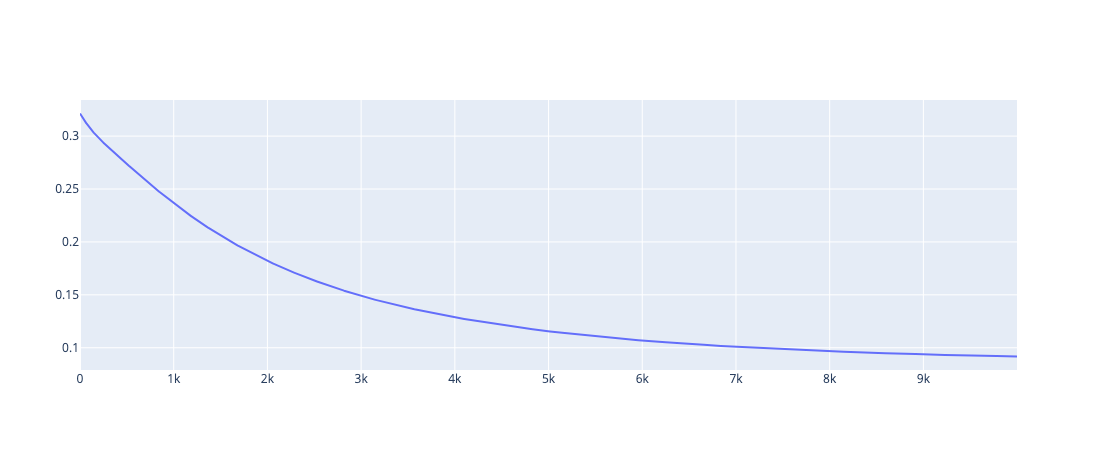

In [158]:
import plotly.graph_objects as go
trace = go.Scatter(y = train_losses)
go.Figure(trace)

### Summary

In this lesson, we saw how to perform gradient descent, and how to train a neural network in Pytorch.  As we know, with gradient descent we repeatedly update our parameters to descend along a cost curve.  And we are able to do so efficiently by finding the slope of the cost curve at a given value.

<img src="cost-curve-slopes.png" width="40%">

And then descending along the cost curve with the formula:

$\theta_{next} = \theta_{current} -\eta*slope\_at(\theta_{current})$

Where $\theta$ is our parameter (above our weight $w_1$), and $\eta$ is our learning rate.  With Pytorch, we first initialize our loss function and our learning rate.

In [159]:
loss = torch.nn.MSELoss() 

optim = torch.optim.Adam(net.parameters(), lr = .001)

And then we repeatedly update our parameters.  In the code above, we perform the procedure 10,000 times to descend along our cost curve.

```python
n_epochs=10000
for it in range(n_epochs): 
    outputs = net(X_tensor) # 1. Make the prediction
    loss = criterion(outputs, y_tensor.view(-1, 1)) # 2. See how off the prediction is according to the cost function
    optim.zero_grad() # Here we zero out any previously calculated slopes
    loss.backward() # 3. Then calculate the slope of the cost curve at that weight
    optim.step() # 4. Update the parameters based on the learning rate and the calculated slope 
```

And updates the parameters in our neural network to descend along the cost curve such that it more accurately predicts the target value -- here, whether or not a cell is cancerous.

Of course, the neural network above is not very good -- it's only is with one neuron, and using a single feature.  But don't fret, in the next lesson we'll jump ahead to build a professional grade neural network that can perform image recognition.  And while we may not understand *every step* along the way -- we'll see how far we've come, as well what's left to cover.

<center>
<a href="https://www.jigsawlabs.io/free" style="position: center"><img src="jigsaw-icon.png" width="15%" style="text-align: center"></a>
</center>